In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

%matplotlib inline

In [2]:
!pip install ultralytics

Visualize The Dataset

In [3]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [4]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)

        thickness = max(2, int(w / 275))

        cv2.rectangle(
            image, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=thickness
        )
    return image

In [5]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths + "/*.jpg"))
    all_images.extend(glob.glob(image_paths + "/*.JPG"))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images - 1)
        image_name = all_images[j]
        image_name = ".".join(image_name.split(os.path.sep)[-1].split(".")[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name + ".txt"), "r") as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(" ")
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i + 1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis("off")
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

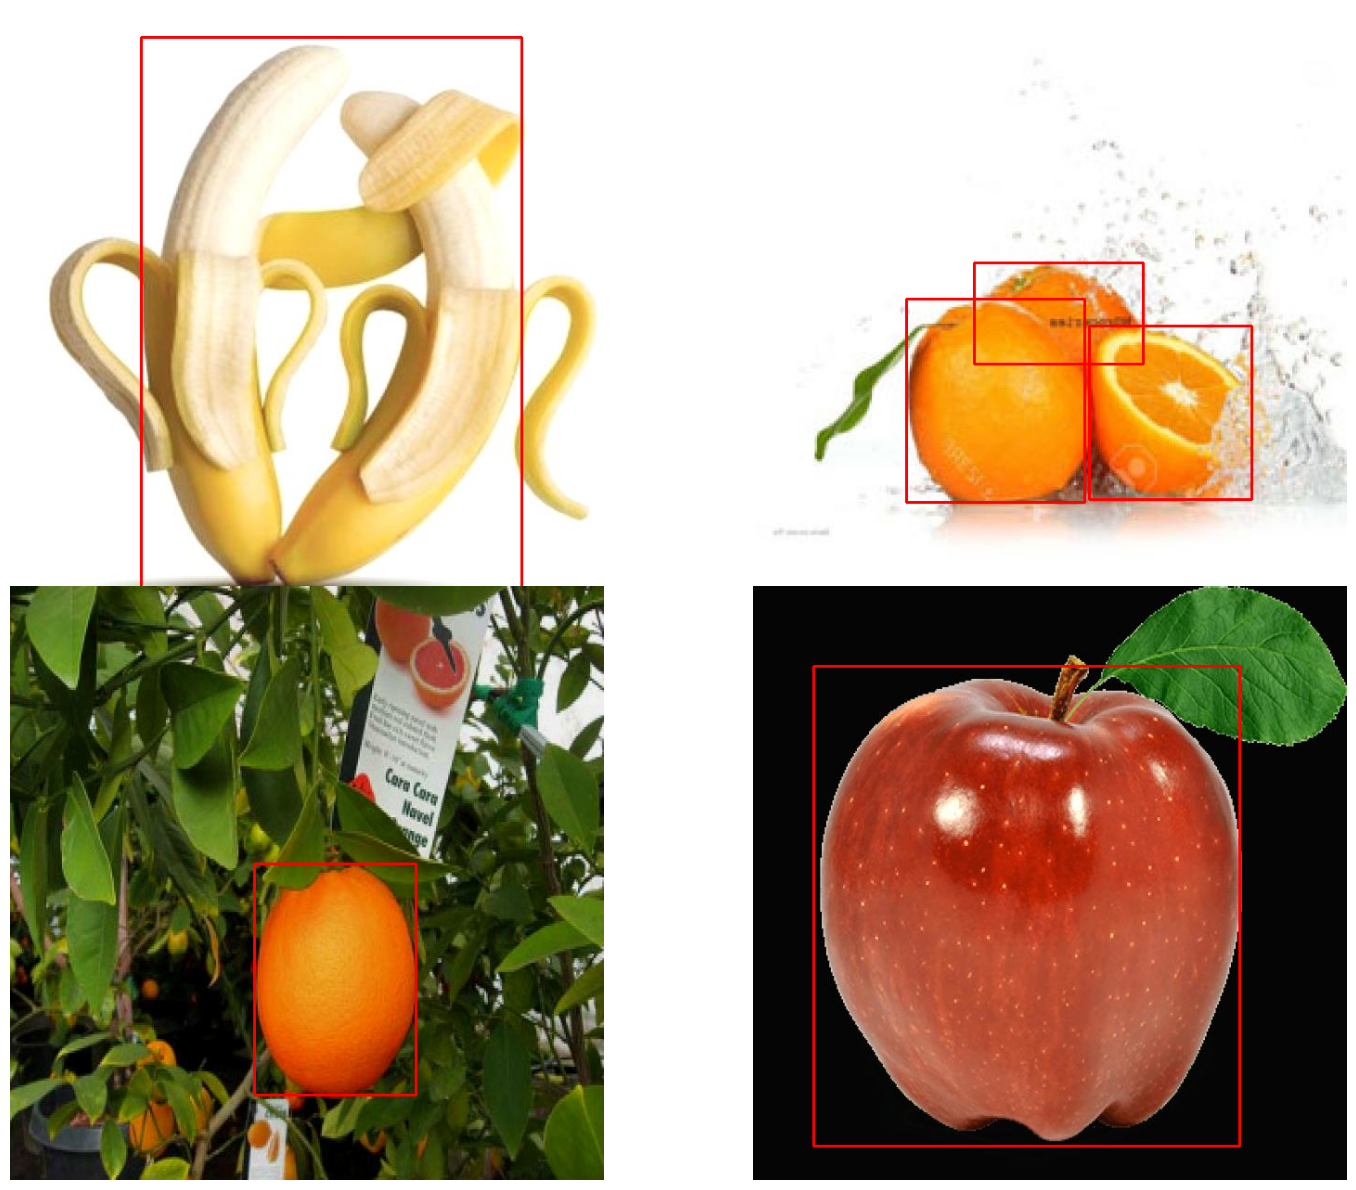

In [7]:
# Visualize a few training images.
plot(
    image_paths="datasets/train/images",
    label_paths="datasets/train/labels/",
    num_samples=4,
)

In [9]:
import os

def get_class_labels(dataset_path):
    class_labels = set()
    # Iterate over the dataset directory
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Assuming the file contains the class label in its name
            # Extract the class label from the file name
            class_label = os.path.basename(root)
            class_labels.add(class_label)
    return class_labels


# Example usage
dataset_path = "datasets"
class_labels = get_class_labels(dataset_path)
print("Class labels:", class_labels)

Class labels: {'labels', 'datasets', 'valid', 'train', 'images'}


In [51]:
# settings
MODEL = "yolov8x.pt"  

from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - banana, appple, orange
CLASS_ID = [46, 47, 49]
# print (CLASS_NAMES_DICT)

# Define the classes you want to remove
classes_of_interest = ["banana", "apple", "orange"]

# Create a new dictionary without the classes to delete
filtered_class_names_dict = {
    class_id: class_name
    for class_id, class_name in CLASS_NAMES_DICT.items()
    if class_name in classes_of_interest
}

# Update CLASS_NAMES_DICT with the filtered dictionary
CLASS_NAMES_DICT = filtered_class_names_dict

# Print the updated dictionary
print(CLASS_NAMES_DICT)

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs
{46: 'banana', 47: 'apple', 49: 'orange'}


In [53]:
# Assume predictions is a list of tuples (class_id, confidence, bbox)
# Example predictions
predictions = [
    (46, 0.85, [10, 20, 100, 150]),  # Example prediction for class 46 (banana)
    (47, 0.75, [50, 60, 200, 250]),  # Example prediction for class 47 (apple)
    (49, 0.80, [70, 80, 300, 350]),  # Example prediction for class 49 (orange)
]

# Define the class IDs of wanted labels
wanted_labels = [46, 47, 49]

# Filter out predictions for wanted labels
filtered_predictions = [
    (class_id, confidence, bbox)
    for class_id, confidence, bbox in predictions
    if class_id in wanted_labels
]

# Process or display the filtered predictions
for class_id, confidence, bbox in filtered_predictions:
    # Process or display the prediction
    print(f"Class ID: {class_id}, Confidence: {confidence}, Bounding Box: {bbox}")


# Define the class IDs of unwanted labels
wanted_labels = [46, 47, 49]

# Filter out predictions for unwanted labels
filtered_predictions = [
    (class_id, confidence, bbox)
    for class_id, confidence, bbox in predictions
    if class_id in wanted_labels
]

# Process or display the filtered predictions
for class_id, confidence, bbox in filtered_predictions:
    # Process or display the prediction
    print(f"Class ID: {class_id}, Confidence: {confidence}, Bounding Box: {bbox}")

Class ID: 46, Confidence: 0.85, Bounding Box: [10, 20, 100, 150]
Class ID: 47, Confidence: 0.75, Bounding Box: [50, 60, 200, 250]
Class ID: 49, Confidence: 0.8, Bounding Box: [70, 80, 300, 350]
Class ID: 46, Confidence: 0.85, Bounding Box: [10, 20, 100, 150]
Class ID: 47, Confidence: 0.75, Bounding Box: [50, 60, 200, 250]
Class ID: 49, Confidence: 0.8, Bounding Box: [70, 80, 300, 350]


In [54]:
%%writefile fruit_v8.yaml
#path: 'datasets/'
train: 'train/images'
val: 'valid/images'

# class names
names: 
  0: 'labels'

Overwriting fruit_v8.yaml


In [55]:
# Sample training for 5 epoch.
EPOCHS = 25
!yolo task=detect mode=train model=yolov8x.pt imgsz=800 data=datasets/data.yaml epochs={EPOCHS} batch=16 name=yolov8x_v8_50e

Ultralytics YOLOv8.1.42 🚀 Python-3.11.8 torch-2.2.2+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=datasets/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8x_v8_50e9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh


train: Scanning C:\Users\srishti\OneDrive\Desktop\yolo\datasets\train\labels.cache... 602 images, 0 backgrounds, 0 corrupt: 100%|██████████| 602/602 [00:00<?, ?it/s]
train: Scanning C:\Users\srishti\OneDrive\Desktop\yolo\datasets\train\labels.cache... 602 images, 0 backgrounds, 0 corrupt: 100%|██████████| 602/602 [00:00<?, ?it/s]

val: Scanning C:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]
val: Scanning C:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]


In [56]:
!yolo task=detect mode=val model=yolov8x.pt name=yolov8x_eval data=datasets/data.yaml epochs=25 imgsz=800 plots=True

Ultralytics YOLOv8.1.42 🚀 Python-3.11.8 torch-2.2.2+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 20, len(boxes) = 63. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                   all         36         63     0.0317     0.0171     0.0183    0.00876
                person         36         39     0.0952     0.0513     0.0548     0.0263
               bicycle         36         23          0          0          0          0
                   car         36          1          0          0          0          0
Speed: 5.7ms preprocess, 4293.9ms inference, 0.1ms loss, 14.3ms postprocess per image
Results saved to runs\detect\yolov8x_eval7
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]
val: Scanning C:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [01:10<02:20, 70.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [02:10<01:04, 64.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [02:36<00:00, 46.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [02:36<00:00, 52.29s/it]


In [57]:
!yolo task=detect \
mode=predict \
model=yolov8x.pt \
source=datasets/valid/images \
imgsz=800 \
name=yolov8x_v8_50e \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.1.42 🚀 Python-3.11.8 torch-2.2.2+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

image 1/36 c:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\images\apple_13_jpg.rf.e8d3cc9f462a30cdf3f8e9c6a3b78ef2.jpg: 800x800 3 apples, 6315.6ms
image 2/36 c:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\images\apple_20_jpg.rf.4fbcb0661bae62196197ce9c7d170a0f.jpg: 800x800 (no detections), 5508.1ms
image 3/36 c:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\images\apple_25_jpg.rf.2a9665aed438c1d8cbdc5568d4b640bb.jpg: 800x800 2 apples, 5639.4ms
image 4/36 c:\Users\srishti\OneDrive\Desktop\yolo\datasets\valid\images\apple_28_jpg.rf.9b904dd1cb7e889f454eda1db4a45439.jpg: 800x800 1 apple, 5760.1ms
image 5/36 c:\Users\srishti\OneDrive\Desktop\yolo\

In [58]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, "*.jpg"))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        if i == num_samples - 1:
            break
    plt.tight_layout()
    plt.show()

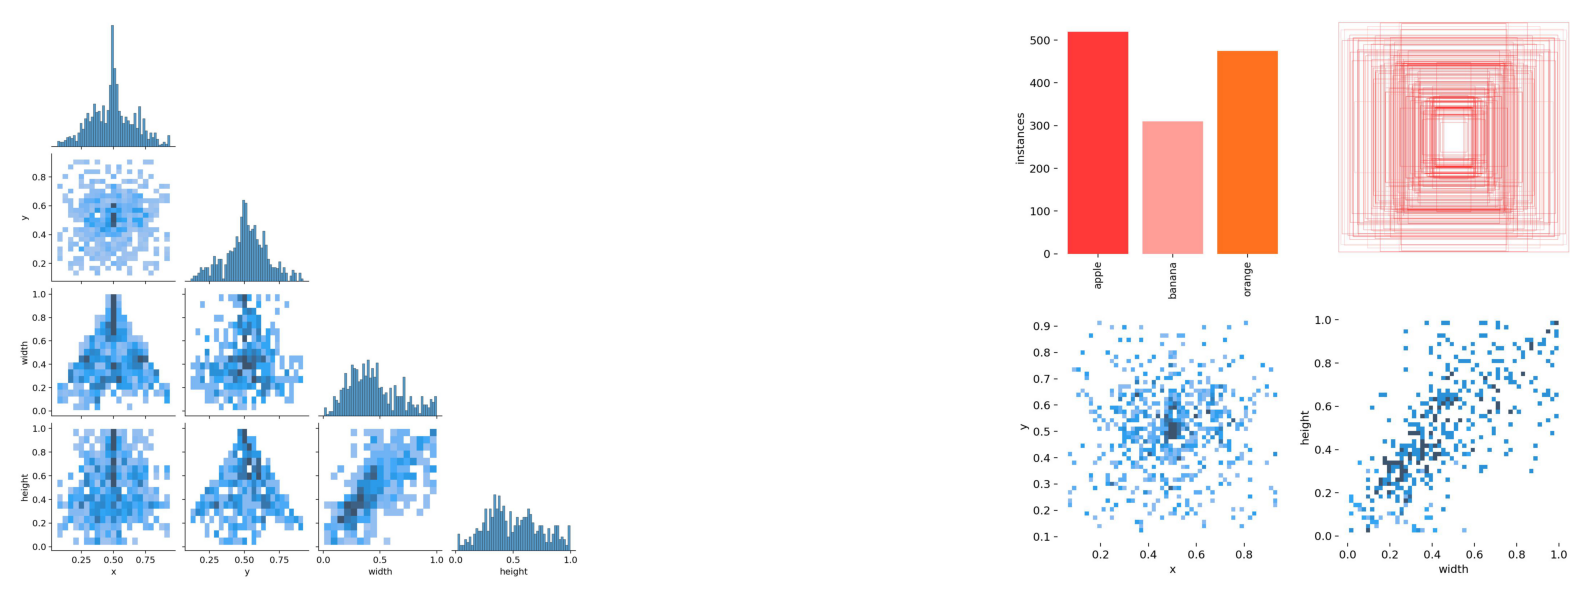

In [59]:
visualize("runs/detect/yolov8x_v8_50e/")